### Finding out topics in tweets

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### Import dataset
- Looking over 23,000 tweets directed at Translink and find out the common topics in the tweets

In [2]:
df=pd.read_csv('data/tweet_data.csv')
df.head()

,TweetID,ScreenName,TweetText,TweetDateTime,Followers,SentimentPolarity
0,1043979473656328192,ScienceOfSmut,Ok there’s a problem train at Broadway Station...,2018-09-23 21:44:37,1171,0.091343
1,1043981305329774592,ScienceOfSmut,HALLELU! Our #skytrain is moving again. @trans...,2018-09-23 21:51:54,1171,0.314101
2,1043981487815553024,itsrho,@TransLink well youre@403 Bridgeport never sho...,2018-09-23 21:52:37,6,0.250553
3,1043981809833267200,ScienceOfSmut,Aaaaand we’ve stopped... #spoketoosoon #stopth...,2018-09-23 21:53:54,1171,0.119664
4,1043981814409261056,huynh_patrick1,@TransLink I keep hearing a skytrain announcem...,2018-09-23 21:53:55,3,0.198395


In [3]:
df.shape

(23581, 6)

In [4]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/franciumpnc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Prepare the data for modelling. 
- remove links
- remove retweet
- remove tweeted at
- lowercase
- strip punctuation
- remove double spacing
- remove numbers
- remove distracting single quotes
- remove stopwords
- apply word rooter

In [5]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [6]:
punctuation = list(string.punctuation)
my_stopwords = nltk.corpus.stopwords.words('english')+ punctuation + ['rt', 'via']
newStopWords = ['translink','transit','vancouver','skytrain','station','people','go','one','thank','time','stop','train','bu']
my_stopwords.extend(newStopWords)

word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet = re.sub("\'","",tweet) # Remove distracting single quotes
    
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [7]:
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

def strip_emoji(text):
    return RE_EMOJI.sub(r'', text)

In [8]:
df['clean_tweet'] = df.TweetText.apply(clean_tweet)

In [9]:
df['clean_tweet'] = df.clean_tweet.apply(strip_emoji)

In [10]:
#Convert to list
data=df.clean_tweet.values.tolist()
data[:20]

['ok there’ problem broadway current i’m stuck outsid nanaimo a… ',
 'hallelu #skytrain move ',
 ' well your  bridgeport never show  pm  road',
 'aaaaand we’v stop #spoketoosoon #stopthistrainiwannagetoff #skytrainfail ',
 ' keep hear announc stuff control center can’t hear it’ saying… ',
 ' where’  p  bu nd still hasn’t shown ',
 ' done thank twitter desk know feedback form differ',
 ' ouch feel asham ',
 '     show',
 ' retir damn mark train hear anyth tho',
 ' littl grill station ',
 ' link success help la',
 ' work mani new car recent ord',
 ' guess want pay ride ',
 ' welp goe perfect opportun final get cat bu ',
 ' display scott road dead pixel say “trai to” instead “train to”',
 ' creat lane strictli buse goal lot cheaper see',
 ' pretti sure pa',
 ' eb side',
 ' enough litter']

In [11]:
"""Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations."""

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True,min_len=1))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

### Check how the tweets looks like after processing

In [12]:
print(df.TweetText[:4])
print('------')
print(data[:4])
print('------')
print(data_words[:4])

0    Ok there’s a problem train at Broadway Station...
1    HALLELU! Our #skytrain is moving again. @trans...
2    @TransLink well youre@403 Bridgeport never sho...
3    Aaaaand we’ve stopped... #spoketoosoon #stopth...
Name: TweetText, dtype: object
------
['ok there’ problem broadway current i’m stuck outsid nanaimo a… ', 'hallelu #skytrain move ', ' well your  bridgeport never show  pm  road', 'aaaaand we’v stop #spoketoosoon #stopthistrainiwannagetoff #skytrainfail ']
------
[['ok', 'there', 'problem', 'broadway', 'current', 'i', 'm', 'stuck', 'outsid', 'nanaimo', 'a'], ['hallelu', 'skytrain', 'move'], ['well', 'your', 'bridgeport', 'never', 'show', 'pm', 'road'], ['aaaaand', 'we', 'v', 'stop', 'spoketoosoon', 'skytrainfail']]


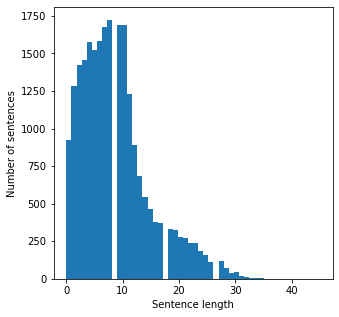

In [13]:
sentence_lengths = [len(tokens) for tokens in data_words]
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths,bins=50)
plt.show()

#### Words in vacabulary and maximum sentence length

In [14]:
all_words =[word for token in data_words for word in token]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

204462 words total, with a vocabulary size of 11821
Max sentence length is 45


In [15]:
""" Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.
Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc."""
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Look at a few tweets after processing

In [16]:
for i in range(0,8):
    print(df.TweetText[i])
# See trigram example
    print(trigram_mod[bigram_mod[data_words[i]]])
# See bigram example
    print(bigram_mod[data_words[i]])
    print('-------')

Ok there’s a problem train at Broadway Station. Currently I’m stuck just outside Nanaimo Station. @TransLink  why a… https://t.co/RDSgEked9u
['ok', 'there', 'problem', 'broadway', 'current', 'i_m', 'stuck', 'outsid', 'nanaimo', 'a']
['ok', 'there', 'problem', 'broadway', 'current', 'i_m', 'stuck', 'outsid', 'nanaimo', 'a']
-------
HALLELU! Our #skytrain is moving again. @translink
['hallelu', 'skytrain', 'move']
['hallelu', 'skytrain', 'move']
-------
@TransLink well youre@403 Bridgeport never showed up for 2:45pm 3 road
['well', 'your', 'bridgeport', 'never', 'show', 'pm', 'road']
['well', 'your', 'bridgeport', 'never', 'show', 'pm', 'road']
-------
Aaaaand we’ve stopped... #spoketoosoon #stopthistrainiwannagetoff #skytrainfail @TransLink
['aaaaand', 'we_v', 'stop', 'spoketoosoon', 'skytrainfail']
['aaaaand', 'we', 'v', 'stop', 'spoketoosoon', 'skytrainfail']
-------
@TransLink I keep hearing a skytrain announcement about stuff from control center but I can’t hear what it’s saying… ht

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
stop_words=my_stopwords

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
        #texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


### Remove stopwords, Lemmatization (the process of converting a word to its base form)

In [18]:

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = lemmatization(data_words_bigrams)


In [19]:
for i in range(0,8):
    print(df.TweetText[i])
    print(data_lemmatized[i])
    print('-------')

Ok there’s a problem train at Broadway Station. Currently I’m stuck just outside Nanaimo Station. @TransLink  why a… https://t.co/RDSgEked9u
['ok', 'problem', 'broadway', 'current', 'stuck', 'outsid', 'nanaimo']
-------
HALLELU! Our #skytrain is moving again. @translink
['hallelu', 'move']
-------
@TransLink well youre@403 Bridgeport never showed up for 2:45pm 3 road
['well', 'bridgeport', 'never', 'show', 'pm', 'road']
-------
Aaaaand we’ve stopped... #spoketoosoon #stopthistrainiwannagetoff #skytrainfail @TransLink
['aaaaand', 'spoketoosoon', 'skytrainfail']
-------
@TransLink I keep hearing a skytrain announcement about stuff from control center but I can’t hear what it’s saying… https://t.co/PhSz5ovtRt
['keep', 'hear', 'announc', 'stuff', 'control', 'center', 'hear', 'say']
-------
@TransLink where’s the 3:08p 340 bus at 22nd station?? It still hasn’t shown up.
['nd', 'still', 'show']
-------
@GabrielBauman @TransLink Done! thanks @TransLink Twitter desk. I know you and the feedbac

In [20]:
all_words =[word for token in data_lemmatized for word in token]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

178276 words total, with a vocabulary size of 11761
Max sentence length is 45


### Sanity check: make sure the code is doing what I think it is doing

In [21]:
aa=[['ok', 'problem', 'broadway','broadway', 'current', 'stuck', 'outsid', 'nanaimo',
     'nanaimo','nanaimo'],['hallelu', 'move','move']]
# Create Dictionary
id2word = corpora.Dictionary(aa)
# Create Corpus
texts = aa
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(texts)
print(corpus)
for i in np.arange(0,9):
    print(i,id2word[i])

[['ok', 'problem', 'broadway', 'broadway', 'current', 'stuck', 'outsid', 'nanaimo', 'nanaimo', 'nanaimo'], ['hallelu', 'move', 'move']]
[[(0, 2), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 2)]]
0 broadway
1 current
2 nanaimo
3 ok
4 outsid
5 problem
6 stuck
7 hallelu
8 move


#### Now get ready for LDA

In [22]:
"""The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
"""
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
for i in range(0,5):
    print(df.TweetText[i])
    print(data_lemmatized[i])
    print(corpus[i])
print('------')    
print('length of vocabulary',len(id2word))    

Ok there’s a problem train at Broadway Station. Currently I’m stuck just outside Nanaimo Station. @TransLink  why a… https://t.co/RDSgEked9u
['ok', 'problem', 'broadway', 'current', 'stuck', 'outsid', 'nanaimo']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]
HALLELU! Our #skytrain is moving again. @translink
['hallelu', 'move']
[(7, 1), (8, 1)]
@TransLink well youre@403 Bridgeport never showed up for 2:45pm 3 road
['well', 'bridgeport', 'never', 'show', 'pm', 'road']
[(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]
Aaaaand we’ve stopped... #spoketoosoon #stopthistrainiwannagetoff #skytrainfail @TransLink
['aaaaand', 'spoketoosoon', 'skytrainfail']
[(15, 1), (16, 1), (17, 1)]
@TransLink I keep hearing a skytrain announcement about stuff from control center but I can’t hear what it’s saying… https://t.co/PhSz5ovtRt
['keep', 'hear', 'announc', 'stuff', 'control', 'center', 'hear', 'say']
[(18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1)]
------
length of vocabu

In [23]:
"""what word a given id corresponds"""
for i in np.arange(0,22):
    print(i,id2word[i])

0 broadway
1 current
2 nanaimo
3 ok
4 outsid
5 problem
6 stuck
7 hallelu
8 move
9 bridgeport
10 never
11 pm
12 road
13 show
14 well
15 aaaaand
16 skytrainfail
17 spoketoosoon
18 announc
19 center
20 control
21 hear


In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('broadway', 1),
  ('current', 1),
  ('nanaimo', 1),
  ('ok', 1),
  ('outsid', 1),
  ('problem', 1),
  ('stuck', 1)],
 [('hallelu', 1), ('move', 1)],
 [('bridgeport', 1),
  ('never', 1),
  ('pm', 1),
  ('road', 1),
  ('show', 1),
  ('well', 1)],
 [('aaaaand', 1), ('skytrainfail', 1), ('spoketoosoon', 1)],
 [('announc', 1),
  ('center', 1),
  ('control', 1),
  ('hear', 2),
  ('keep', 1),
  ('say', 1),
  ('stuff', 1)]]

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [26]:
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"like" + 0.031*"good" + 0.019*"want" + 0.019*"even" + 0.017*"great" + '
  '0.016*"thing" + 0.016*"open" + 0.015*"issu" + 0.014*"guy" + 0.013*"give"'),
 (1,
  '0.035*"wait" + 0.034*"come" + 0.030*"driver" + 0.028*"know" + 0.019*"run" + '
  '0.019*"rout" + 0.019*"delay" + 0.017*"way" + 0.015*"hey" + 0.012*"long"'),
 (2,
  '0.024*"say" + 0.023*"take" + 0.019*"make" + 0.018*"show" + 0.018*"happen" + '
  '0.016*"still" + 0.016*"well" + 0.016*"min" + 0.014*"look" + 0.014*"new"'),
 (3,
  '0.029*"work" + 0.024*"use" + 0.024*"would" + 0.019*"day" + 0.014*"car" + '
  '0.014*"today" + 0.013*"snow" + 0.013*"plea" + 0.011*"hour" + '
  '0.011*"realli"'),
 (4,
  '0.055*"get" + 0.040*"line" + 0.026*"buse" + 0.025*"see" + 0.019*"late" + '
  '0.018*"minut" + 0.018*"servic" + 0.018*"need" + 0.016*"amp" + '
  '0.014*"think"')]


In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.18439753765067

Coherence Score:  0.23269335372455488


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.365876 -0.075172       1        1  24.061599
2     -0.177994 -0.318186       2        1  22.115871
1     -0.086335  0.217994       3        1  19.505071
3     -0.064793  0.137880       4        1  19.081440
0     -0.036754  0.037484       5        1  15.236018, topic_info=     Term         Freq        Total Category  logprob  loglift
59    get  2354.000000  2354.000000  Default  30.0000  30.0000
100  line  1711.000000  1711.000000  Default  29.0000  29.0000
102  wait  1223.000000  1223.000000  Default  28.0000  28.0000
281  like  1055.000000  1055.000000  Default  27.0000  27.0000
109  come  1189.000000  1189.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
384  okay   157.047248   157.769493   Topic5  -5.1530   1.8769
122  caus   154.969551   155.689148   Topic5  -5.1664   1.8769
670  away   152.630956   153.350039   Topic5  -5.1816   1.8768
895  free   144.402320   145.115006   Topic5  -5.2370   1.8766
34   feel   144.665330   145.379778   Topic5  -5.2352   1.8766

[182 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
193       1  0.997657     -PRON-
503       4  0.996468     actual
180       3  0.998475       also
588       5  0.997743      alway
207       1  0.999552        amp
...     ...       ...        ...
269       4  0.999644      would
6294      4  0.996435  wristband
899       3  0.994114      wrong
428       1  0.997044         ye
221       3  0.996586       year

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1])

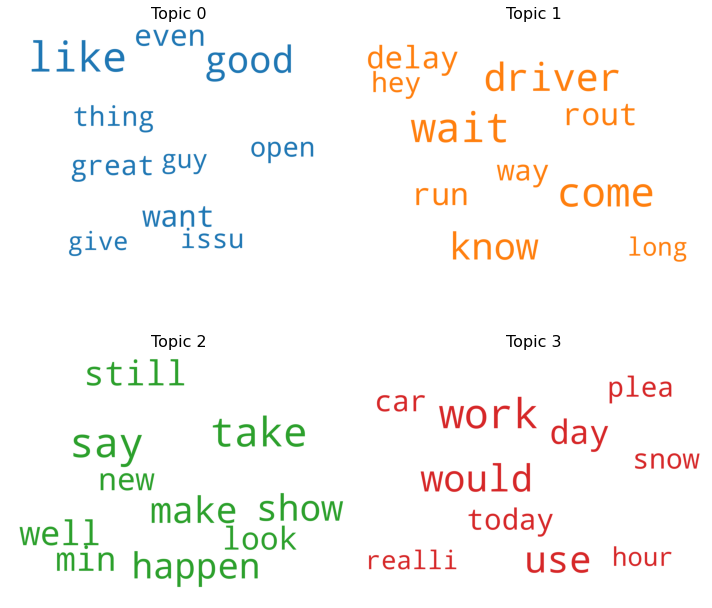

In [29]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Try Mallet LDA

In [30]:
import os
#mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
mallet_path = 'Mallet/bin/mallet'
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
from gensim.models.wrappers import LdaMallet

In [31]:
from gensim.models.wrappers import LdaMallet

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,corpus=corpus, num_topics=5, id2word=id2word)

In [32]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('make', 0.03031011115932837),
   ('day', 0.02550322128384017),
   ('amp', 0.024802216510331473),
   ('work', 0.019761658377007045),
   ('great', 0.01595620389224555),
   ('pay', 0.011950462329338718),
   ('surrey', 0.011082551657375572),
   ('plan', 0.011015789297993791),
   ('ride', 0.011015789297993791),
   ('tri', 0.010414928063557765)]),
 (1,
  [('driver', 0.041300164925783395),
   ('-PRON-', 0.019584936778449698),
   ('guy', 0.014808960967564596),
   ('drive', 0.013881253435953821),
   ('realli', 0.013159703133589884),
   ('give', 0.011682242990654205),
   ('day_giveaway', 0.01154480483782298),
   ('tlday', 0.011373007146783947),
   ('hey', 0.01075453545904343),
   ('enter_win', 0.010514018691588784)]),
 (2,
  [('good', 0.02356119413192901),
   ('today', 0.020893889135861574),
   ('year', 0.015080532093150498),
   ('issu', 0.014328215299387888),
   ('hope', 0.011147967034845946),
   ('thing', 0.010806004855862942),
   ('work', 0.01070341620216804),
   ('announc', 0.010395

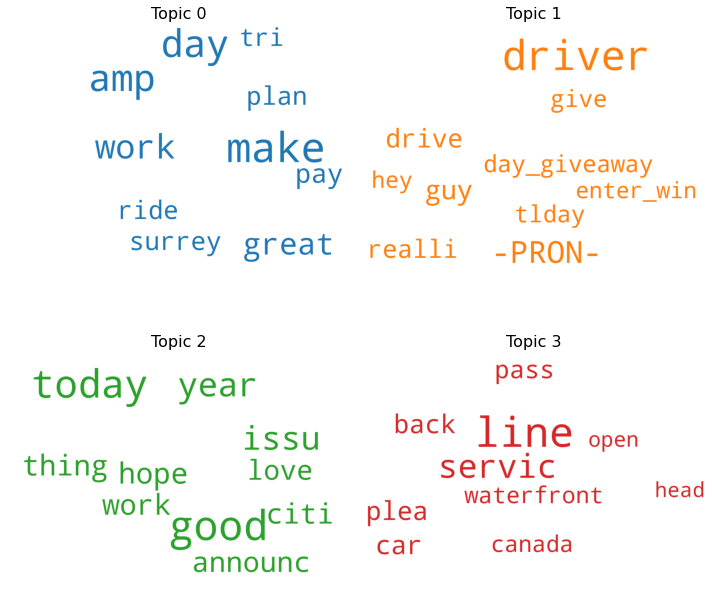

In [33]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamallet.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [34]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.2381,"line, servic, car, plea, back, pass, waterfron...",ok there’ problem broadway current i’m stuck o...
1,1,0.0,0.2115,"make, day, amp, work, great, pay, surrey, plan...",hallelu #skytrain move
2,2,4.0,0.2387,"wait, buse, minut, late, show, run, rout, min,...",well your bridgeport never show pm road
3,3,2.0,0.2096,"good, today, year, issu, hope, thing, work, an...",aaaaand we’v stop #spoketoosoon #stopthistrain...
4,4,2.0,0.2262,"good, today, year, issu, hope, thing, work, an...",keep hear announc stuff control center can’t ...
5,5,4.0,0.2157,"wait, buse, minut, late, show, run, rout, min,...",where’ p bu nd still hasn’t shown
6,6,2.0,0.2407,"good, today, year, issu, hope, thing, work, an...",done thank twitter desk know feedback form di...
7,7,0.0,0.2264,"make, day, amp, work, great, pay, surrey, plan...",ouch feel asham
8,8,4.0,0.2157,"wait, buse, minut, late, show, run, rout, min,...",show
9,9,2.0,0.2500,"good, today, year, issu, hope, thing, work, an...",retir damn mark train hear anyth tho
